In [75]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch_cluster import knn_graph
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.optim as optim

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

from networks import *
import mplhep

plt.style.use(mplhep.style.ATLAS)

In [66]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

## Load the data

In [37]:
# let's open the file
data_dir = 'Data-MLtutorial/JetDataset/'
fileIN = data_dir+'jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN)
# and see what it contains
print(list(f.keys()))

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']


## Transformer

In [38]:
target_onehot = np.array([])
jetList = np.array([])
jetImages = np.array([])
mass = np.array([])
features_names = dict()
datafiles = ['jetImage_7_100p_0_10000.h5',
             'jetImage_7_100p_10000_20000.h5',
             'jetImage_7_100p_30000_40000.h5',
             'jetImage_7_100p_40000_50000.h5',
             'jetImage_7_100p_50000_60000.h5'
            ]
for i_f,fileIN in enumerate(datafiles):
    print("Appending %s" %fileIN)
    f = h5py.File(data_dir + fileIN)
    jetList_file = np.array(f.get("jetConstituentList"))
    target_file = np.array(f.get('jets')[0:,-6:-1])
    jetImages_file = np.array(f.get('jetImage'))
    mass = np.concatenate((mass, np.array(f.get("jets")[:,np.array(f["jetFeatureNames"])==b'j_mass']).flatten()))
    jetList = np.concatenate([jetList, jetList_file], axis=0) if jetList.size else jetList_file
    target_onehot = np.concatenate([target_onehot, target_file], axis=0) if target_onehot.size else target_file
    jetImages = np.concatenate([jetImages, jetImages_file], axis=0) if jetImages.size else jetImages_file
    del jetList_file, target_file, jetImages_file
    #save particles/nodes features names and their indecies in a dictionary
    if i_f==0:
      for feat_idx,feat_name in enumerate(list(f['particleFeatureNames'])[:-1]):
        features_names[feat_name.decode("utf-8").replace('j1_','')] = feat_idx
    f.close()

max_mass = np.max(mass)
target_reg = mass/max_mass

Appending jetImage_7_100p_0_10000.h5


/var/folders/12/0hh3vwh15c98tyd4w4bw6dt80000gn/T/ipykernel_77530/1706071539.py:15: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  jetList_file = np.array(f.get("jetConstituentList"))
/var/folders/12/0hh3vwh15c98tyd4w4bw6dt80000gn/T/ipykernel_77530/1706071539.py:17: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  jetImages_file = np.array(f.get('jetImage'))
/var/folders/12/0hh3vwh15c98tyd4w4bw6dt80000gn/T/ipykernel_77530/1706071539.py:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  mass = np.concatenate((mass, np.array(f.get("jets")[:,np.array(f["jetFeatureNames"])==b'j_mass']).flatten()))


Appending jetImage_7_100p_10000_20000.h5
Appending jetImage_7_100p_30000_40000.h5
Appending jetImage_7_100p_40000_50000.h5
Appending jetImage_7_100p_50000_60000.h5


In [39]:
target = np.argmax(target_onehot, axis=1)
num_classes = len(np.unique(target))
label_names= ["gluon", "quark", "W", "Z", "top"]

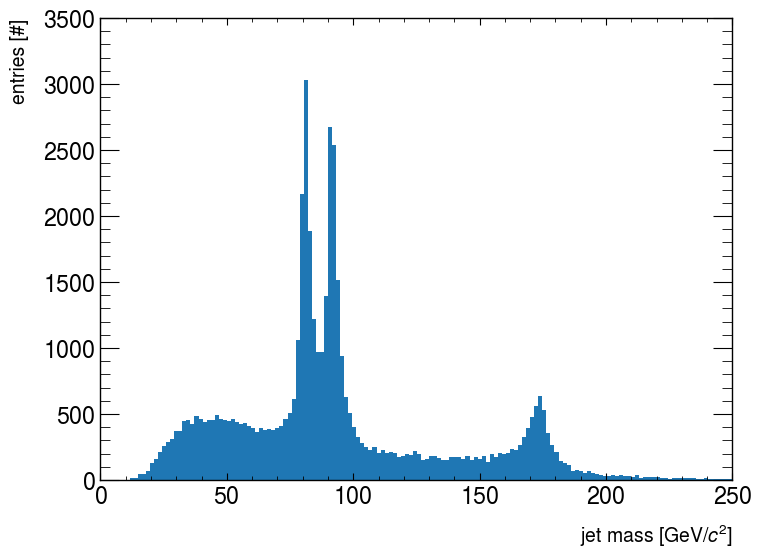

In [76]:
plt.hist(mass, range=[10,250], bins=150)
plt.ylabel("entries [#]")
plt.xlabel(r"jet mass [GeV/$c^2$]")
plt.show()

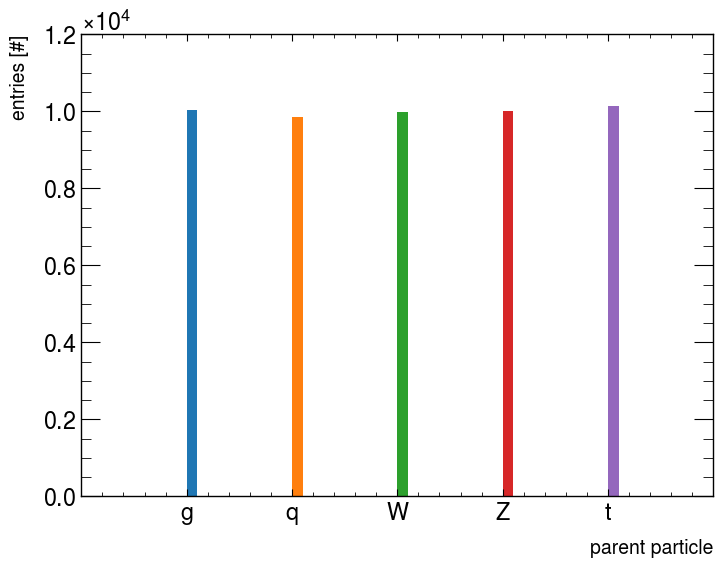

In [77]:
label_names= ["g", "q", "W", "Z", "t"]
for i in range(6):
    plt.hist(target[target==i])
plt.ylabel("entries [#]")
plt.xlabel("parent particle")
plt.xticks([0,1,2,3,4], labels=label_names)
plt.show()

In [78]:
print("Labels for the first five entries in the dataset, one-hot encoded:")
for i in range(5):
    print(target_onehot[i])
print(target_onehot.shape)
target = np.argmax(target_onehot, axis=1)
print(target.shape)
print("Labels for the first five entries in the dataset, single column encoded:")
for i in range(0,5):
    print(target[i])

Labels for the first five entries in the dataset, one-hot encoded:
[1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0.]
(50000, 5)
(50000,)
Labels for the first five entries in the dataset, single column encoded:
0
2
4
4
2


In [79]:
batch_size=64
learning_rate=0.001
epochs=1

In [87]:
num_heads = 8
hidden_dimensions = 64

t_net = TransformerNet(num_heads=num_heads, hidden_units=hidden_dimensions)
r_net = RegNet(hidden_dimensions)
c_net = ClassNet(hidden_dimensions)

inputs = keras.Input(shape=(100,16), name='input')
output = layers.TimeDistributed(layers.Dense(hidden_dimensions))(inputs)
output = t_net(output)
# output = PoolingByMultiHeadAttention(num_heads=num_heads,hidden_units=hidden_dimensions)(output)
output = layers.Lambda(lambda y: tf.reduce_sum(y, axis=1))(output)
output = [r_net(output), c_net(output)]
# output = o_net(output)

model = keras.models.Model(inputs=inputs, outputs=output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 100, 16)]            0         []                            
                                                                                                  
 time_distributed_3 (TimeDi  (None, 100, 64)              1088      ['input[0][0]']               
 stributed)                                                                                       
                                                                                                  
 mab_15 (MAB)                (None, 100, 64)              33472     ['time_distributed_3[0][0]']  
                                                                                                  
 mab_16 (MAB)                (None, 100, 64)              33472     ['mab_15[0][0]']        

In [88]:
model.compile(
    loss=["mse", keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=keras.metrics.SparseCategoricalAccuracy(),
    loss_weights=[0.5,0.5])

In [89]:
from keras_visualizer import visualizer
visualizer(model, file_format='png')

In [83]:
model.save("test.h5")

/Users/jarvis/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
X_train, X_val, y_train_class, y_val_class, y_train_reg, y_val_reg, y_train_onehot, y_val_onehot = train_test_split(jetList, target,target_reg, target_onehot, test_size=0.1, shuffle=True)
print(X_train.shape, X_val.shape, y_train_class.shape, y_val_class.shape, y_train_reg.shape, y_val_reg.shape)
# del jetList, target, target_onehot

(45000, 100, 16) (5000, 100, 16) (45000,) (5000,) (45000,) (5000,)


In [15]:
history = model.fit(x=X_train, 
                    y=[y_train_reg,y_train_class], 
                    validation_data=(X_val,[y_val_reg,y_val_class]), 
                    batch_size=batch_size, 
                    epochs=epochs,
                    verbose=1,
                    callbacks = [ EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                                  TerminateOnNaN()]
                   )

/Users/jarvis/anaconda3/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-08-15 09:43:14.577896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.7173 - Reg_loss: 0.0667 - Class_loss: 1.3680 - Reg_sparse_categorical_accuracy: 0.0000e+00 - Class_sparse_categorical_accuracy: 0.3704

2023-08-15 09:44:57.583635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 112s 154ms/step - loss: 0.7173 - Reg_loss: 0.0667 - Class_loss: 1.3680 - Reg_sparse_categorical_accuracy: 0.0000e+00 - Class_sparse_categorical_accuracy: 0.3704 - val_loss: 0.7711 - val_Reg_loss: 0.0306 - val_Class_loss: 1.5115 - val_Reg_sparse_categorical_accuracy: 0.0000e+00 - val_Class_sparse_categorical_accuracy: 0.3056 - lr: 0.0010


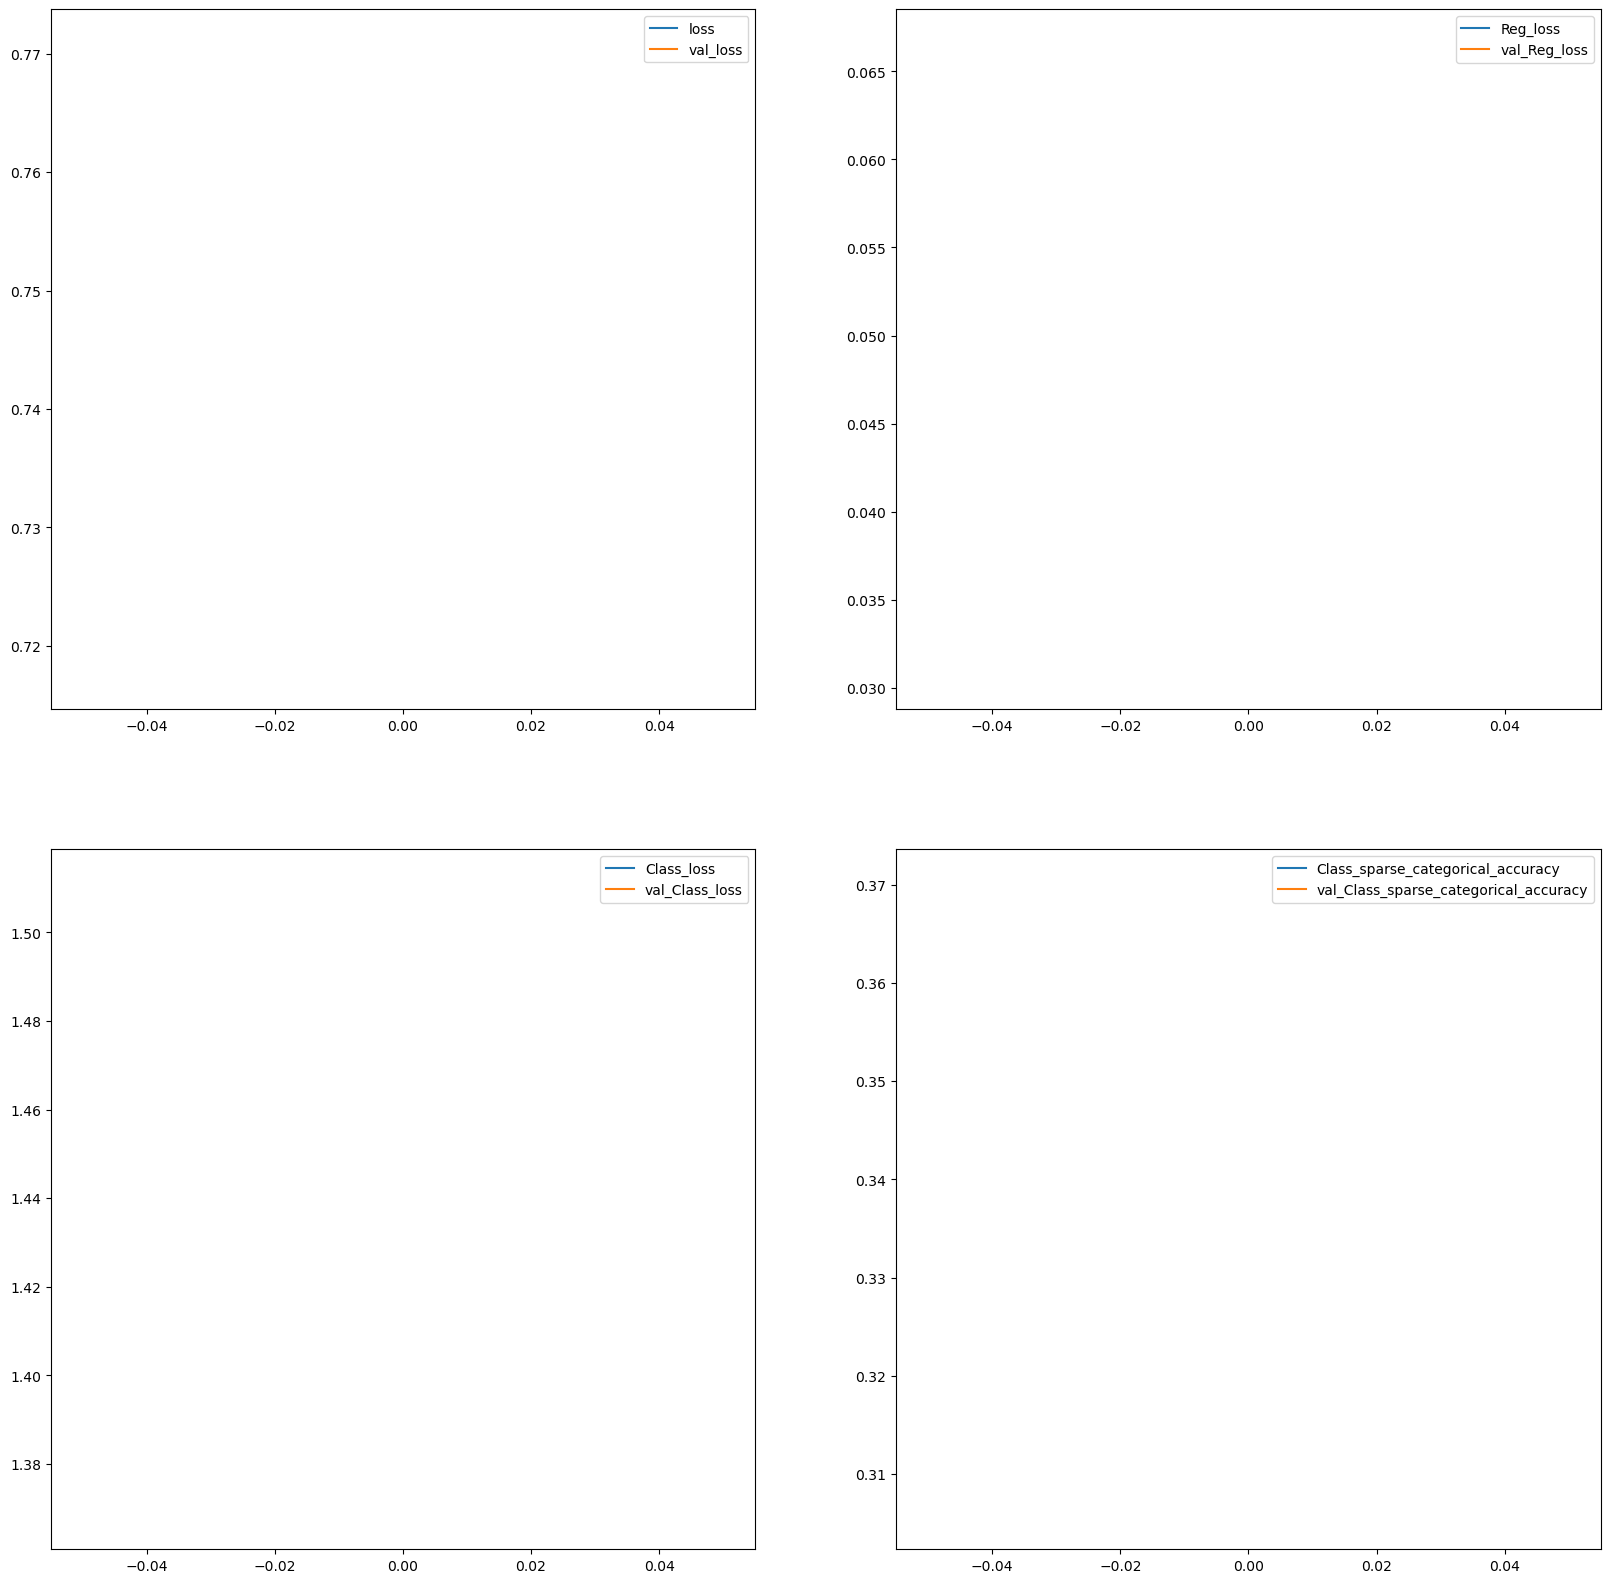

In [16]:
keys = ["loss","Reg_loss","Class_loss","Class_sparse_categorical_accuracy"]
fig,axes = plt.subplots(2,2, figsize=(20,20))
for ax, key in zip(axes.flat, keys):
    ax.plot([i for i in range(len(history.history[key]))],history.history[key],label=key)
    ax.plot([i for i in range(len(history.history[key]))],history.history["val_"+key],label="val_"+key)
    ax.legend()

plt.show()

2023-08-15 09:45:18.413035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 9s 51ms/step


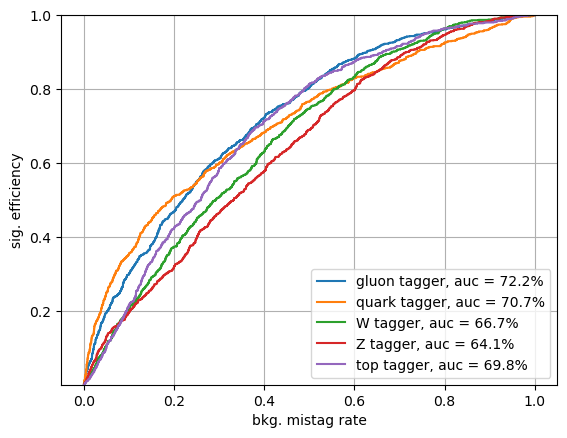

In [17]:
predict_val = tf.nn.softmax(model.predict(X_val)[1]) # index 0 is the regression predictio
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(label_names):

        df[label] = y_val_onehot[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(fpr[label],tpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
#plt.semilogy()
plt.ylabel("sig. efficiency")
plt.xlabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

157/157 [==============================] - 7s 47ms/step


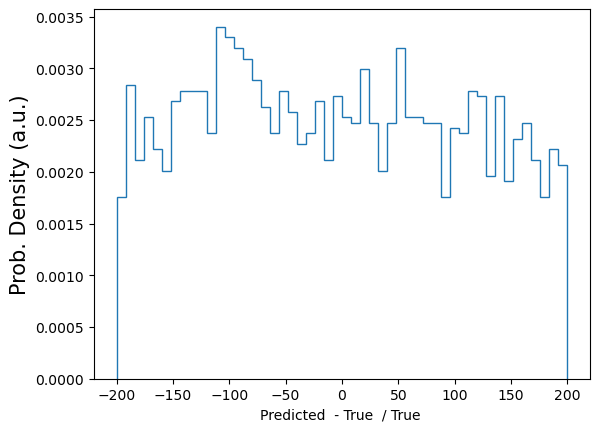

In [19]:
predict_reg = model.predict(X_val)[0].flatten()
plt.hist(((predict_reg-y_val_reg)/y_val_reg)*max_mass,50,(-200,200),density=True,histtype="step")
plt.xlabel("Predicted  - True  / True ")
plt.ylabel('Prob. Density (a.u.)', fontsize=15)
plt.show()

Text(0, 0.5, 'True Label')

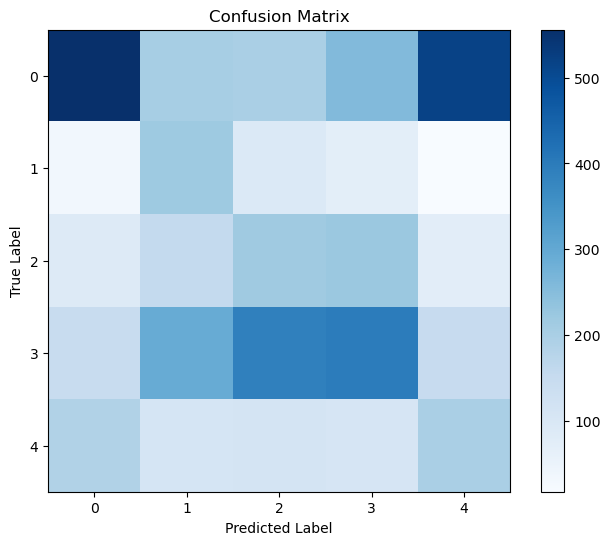

In [20]:
confusion_mat = confusion_matrix(np.argmax(predict_val,axis=1),y_val_class)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### Pure classification -> Regression

In [21]:
### Transformer + classification

batch_size=64
learning_rate=0.001
epochs=1

In [22]:
num_heads = 8
hidden_dimensions = 64

t_net_2 = TransformerNet(num_heads=num_heads, hidden_units=hidden_dimensions)
r_net_2 = RegNet(hidden_dimensions)
c_net_2 = ClassNet(hidden_dimensions)

inputs = keras.Input(shape=(100,16), name='input')
output = layers.TimeDistributed(layers.Dense(hidden_dimensions))(inputs)
output = t_net_2(output)
# output = PoolingByMultiHeadAttention(num_heads=num_heads,hidden_units=hidden_dimensions)(output)
output = layers.Lambda(lambda y: tf.reduce_sum(y, axis=1))(output)
output = [c_net_2(output)]
# output = o_net(output)

model_class = keras.models.Model(inputs=inputs, outputs=output)
model_class.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 16)]         0         
                                                                 
 time_distributed_1 (TimeDi  (None, 100, 64)           1088      
 stributed)                                                      
                                                                 
 mab_3 (MAB)                 (None, 100, 64)           33472     
                                                                 
 mab_4 (MAB)                 (None, 100, 64)           33472     
                                                                 
 mab_5 (MAB)                 (None, 100, 64)           33472     
                                                                 
 lambda_1 (Lambda)           (None, 64)                0         
                                                           

In [23]:
model_class.compile(
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=keras.metrics.SparseCategoricalAccuracy())

In [24]:
X_train, X_val, y_train_class, y_val_class, y_train_reg, y_val_reg, y_train_onehot, y_val_onehot = train_test_split(jetList, target,target_reg, target_onehot, test_size=0.1, shuffle=True)
print(X_train.shape, X_val.shape, y_train_class.shape, y_val_class.shape, y_train_reg.shape, y_val_reg.shape)
# del jetList, target, target_onehot

(45000, 100, 16) (5000, 100, 16) (45000,) (5000,) (45000,) (5000,)


In [25]:
history = model_class.fit(x=X_train, 
                    y=y_train_class, 
                    validation_data=(X_val,y_val_class), 
                    batch_size=batch_size, 
                    epochs=epochs,
                    verbose=1,
                    callbacks = [ EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                                  TerminateOnNaN()]
                   )

/Users/jarvis/anaconda3/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-08-15 10:21:01.556076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 1.3441 - sparse_categorical_accuracy: 0.3821

2023-08-15 10:22:42.765543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 110s 152ms/step - loss: 1.3441 - sparse_categorical_accuracy: 0.3821 - val_loss: 1.7589 - val_sparse_categorical_accuracy: 0.3034 - lr: 0.0010


In [26]:
### Using the transformer output from pure classification to learn the regression model

inputs = keras.Input(shape=(16), name='input')
output = [r_net_2(inputs)]

model_reg = keras.models.Model(inputs=inputs, outputs=output)
model_reg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 16)]              0         
                                                                 
 batch_normalization_3 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 64)                1088      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64)                0         
                                                           

In [27]:
model_reg.compile(
    loss=["mse"],
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=keras.metrics.SparseCategoricalAccuracy())

In [32]:
test = np.vstack((X_train, X_val))

In [33]:
np.shape(test)

(50000, 100, 16)

In [34]:
transformer_output = t_net_2(test)
transformer_output = layers.Lambda(lambda y: tf.reduce_sum(y, axis=1))(transformer_output)

In [29]:
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(transformer_output.numpy(),target_reg, test_size=0.1, shuffle=True)
print(X_train_reg.shape, X_val_reg.shape, y_train_reg.shape, y_val_reg.shape)
# del jetList, target, target_onehot

(45000, 16) (5000, 16) (45000,) (5000,)


In [30]:
history = model_reg.fit(x=X_train_reg, 
                    y=y_train_reg, 
                    validation_data=(X_val_reg,y_val_reg), 
                    batch_size=batch_size, 
                    epochs=epochs,
                    verbose=1,
                    callbacks = [ EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                                  TerminateOnNaN()]
                   )

2023-08-15 10:24:15.278444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - ETA: 0s - loss: 0.0093 - sparse_categorical_accuracy: 0.0000e+00

2023-08-15 10:24:22.381354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


704/704 [==============================] - 8s 10ms/step - loss: 0.0093 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 0.0075 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010


## Graph Networks

In [ ]:
device = "cpu"

In [ ]:
print("Labels for the first five entries in the dataset, one-hot encoded:")
for i in range(5):
    print(target[i])
target = np.argmax(target, axis=1)
print("Labels for the first five entries in the dataset, single column encoded:")
for i in range(0,5):
    print(target[i])

In [ ]:
num_classes = len(np.unique(target))
label_names= ["gluon", "quark", "W", "Z", "top"]

In [ ]:
print('Jets shape : ',jetList.shape)
print('Target/Labels shape : ',target.shape)
print('Particles/Nodes features : ',list(features_names.keys()))

Jets shape :  (50000, 100, 16)
Target/Labels shape :  (50000,)
Particles/Nodes features :  ['px', 'py', 'pz', 'e', 'erel', 'pt', 'ptrel', 'eta', 'etarel', 'etarot', 'phi', 'phirel', 'phirot', 'deltaR', 'costheta', 'costhetarel']


In [ ]:
features_to_consider = 'etarel,phirel,pt,e,ptrel,erel,deltaR'.split(',')
features_idx = [features_names[name] for name in features_to_consider]
jetList = jetList[:,:,features_idx]

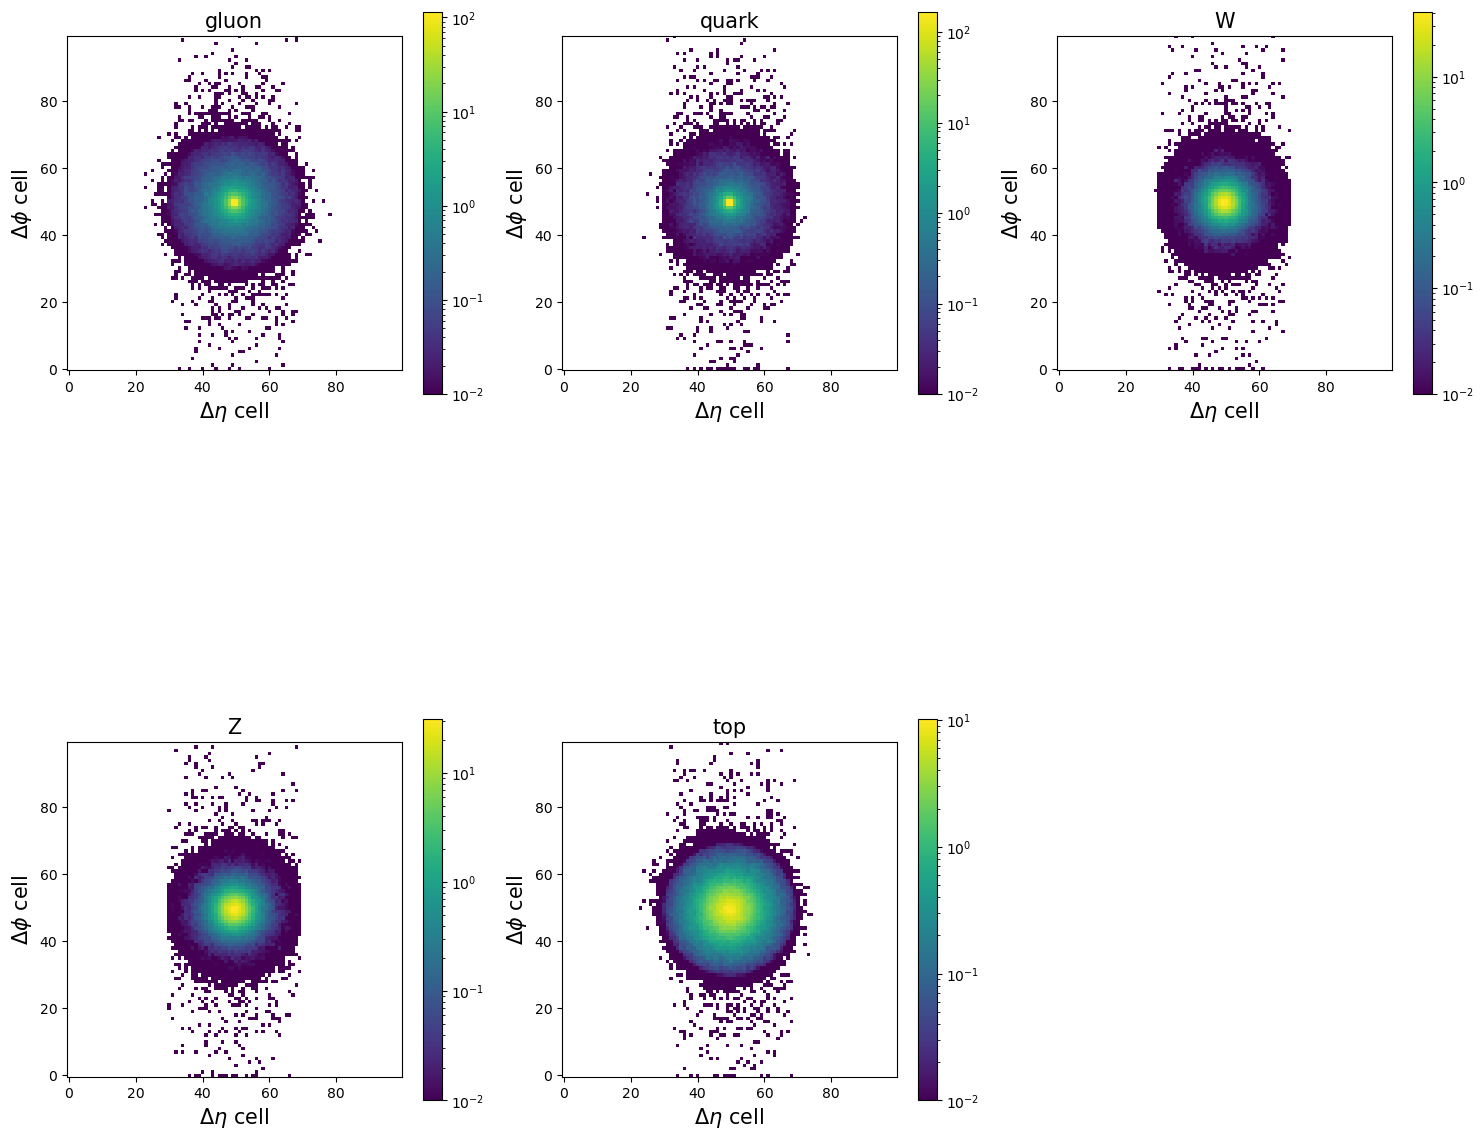

In [ ]:
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(15,15), tight_layout=True)
fig.delaxes(axes[-1, -1])
for i_l, label in enumerate(label_names):
    image = jetImages[target == i_l]
    SUM_Image = np.sum(image, axis = 0)
    im = axes.flat[i_l].imshow(SUM_Image/float(image.shape[0]), origin='lower',norm=LogNorm(vmin=0.01))
    fig.colorbar(im,ax=axes.flat[i_l],shrink=0.5)
    axes.flat[i_l].set_title(label_names[i_l], fontsize=15)
    axes.flat[i_l].set_xlabel(r"$\Delta\eta$ cell", fontsize=15)
    axes.flat[i_l].set_ylabel(r"$\Delta\phi$ cell", fontsize=15)
plt.show()

In [ ]:
#Let's define a helper function to plot the distibutions
def plot_features(feat_idx, input_data, features_to_consider):
    plt.subplots(figsize=(5,5))
    for jet_type_idx in range(len(label_names)):
        data_feature = input_data[:,:,feat_idx]
        data_feature = data_feature[target == jet_type_idx]
        # then plot the right quantity for the reduced array (merge all constituents together)
        plt.hist(data_feature[:,feat_idx].flatten(), bins=50, density=True, histtype='step', fill=False, linewidth=1.5)
    #plt.yscale('log', nonposy='clip')    
    plt.legend(label_names, fontsize=12, frameon=False)  
    plt.xlabel(features_to_consider[feat_idx], fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()

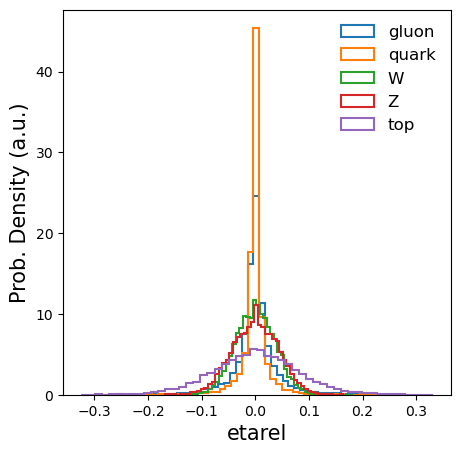

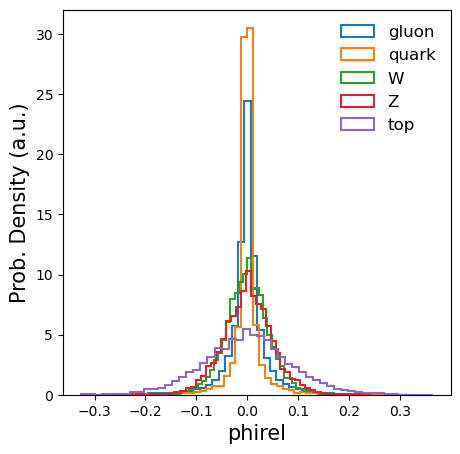

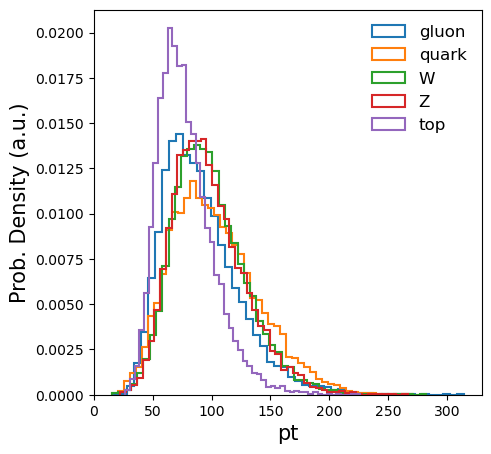

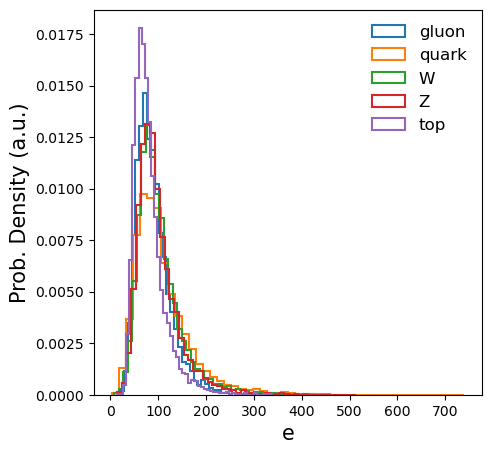

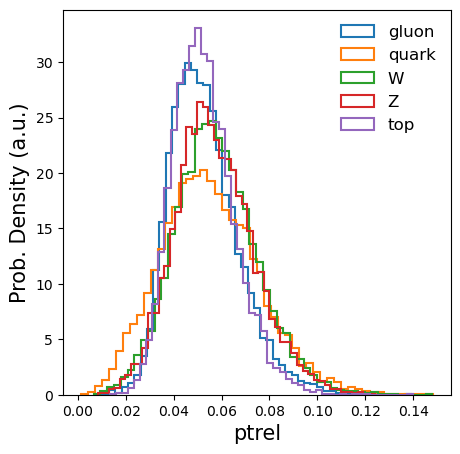

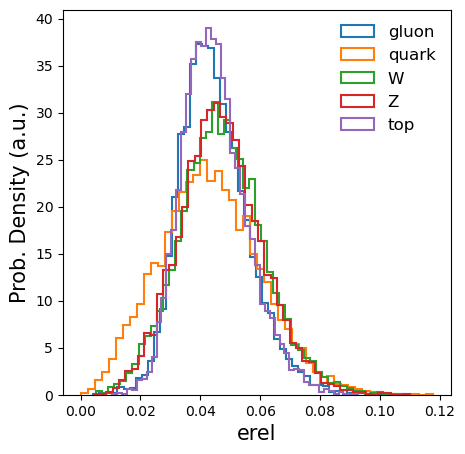

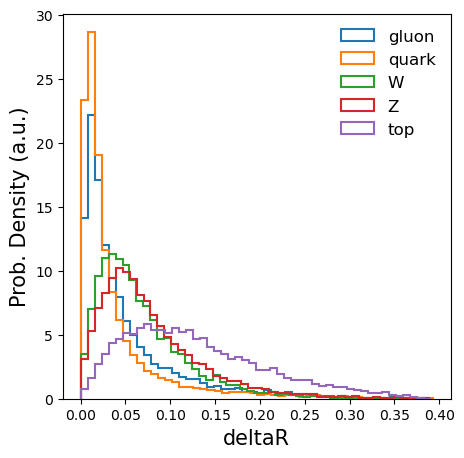

In [ ]:
# we now plot all the features
for i in range(len(features_to_consider)):
    plot_features(i, jetList, features_to_consider)

In [ ]:
class ParticleNetEdgeNet(nn.Module):
    def __init__(self, in_size, layer_size):
        super(ParticleNetEdgeNet, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size)) #undirected graph
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(2):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def __repr__(self):
        return "{}(nn={})".format(self.__class__.__name__, self.model)


class ParticleNet(nn.Module):
    def __init__(self, node_feat_size, num_classes=5):
        super(ParticleNet, self).__init__()
        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.k = 16 #for kNN algo
        self.num_edge_convs = 3 #number of stacked EdgeConv blocks
        self.kernel_sizes = [64, 128, 256] #number of units in the three linear transformation layers in each EdgeConv block
        self.fc_size = 256 #units of the first FC layer after EdgeConv blocks
        self.dropout = 0.1

        self.edge_nets = nn.ModuleList()
        self.edge_convs = nn.ModuleList()

        self.kernel_sizes.insert(0, self.node_feat_size)
        self.output_sizes = np.cumsum(self.kernel_sizes) #inputs include also previous layer output

        #the first EdgeConv block
        self.edge_nets.append(ParticleNetEdgeNet(self.node_feat_size, self.kernel_sizes[1]))
        self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        #stack other two EdgeConv blocks
        for i in range(1, self.num_edge_convs):
            print("self.num_edge_convs",i)
            # adding kernel sizes because of skip connections
            self.edge_nets.append(
                ParticleNetEdgeNet(self.output_sizes[i], self.kernel_sizes[i + 1])
            )
            self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        self.fc1 = nn.Sequential(nn.Linear(self.output_sizes[-1], self.fc_size))

        self.dropout_layer = nn.Dropout(p=self.dropout)

        self.fc2 = nn.Linear(self.fc_size, self.num_classes)

    def forward(self, data):
        # input data is an instance of PyG Data() 
        x = data.x
        batch = data.batch

        for i in range(self.num_edge_convs):
            # using only angular coords eta and phi for knn in the first edgeconv block, computing edge_index.
            edge_index = (
                knn_graph(x[:, :2], self.k, batch) if i == 0 else knn_graph(x, self.k, batch)
            )
            x = torch.cat(
                (self.edge_convs[i](x, edge_index), x), dim=1
            )  # concatenating with original features i.e. skip connection

        x = global_mean_pool(x, batch) # this runs scatter under the hood
        x = self.fc1(x)

        return self.fc2(x)

In [ ]:
num_jets = np.minimum(50000, len(jetList)) #number of training+validation samples. We can start with 10000.
jet_dataset = []
for i_jet in range(num_jets):
    # remove the zero padded particles
    mask_real = np.where(jetList[i_jet,:,features_to_consider.index('e')]>0) # keep only particles where energy is > 0. e.g. real particles
    num_nodes = len(mask_real[0])
    d = Data(x=torch.tensor(jetList[i_jet,mask_real,:].squeeze(), dtype=torch.float), 
             y=torch.tensor(target[i_jet], dtype=torch.long),
             num_nodes = num_nodes)
    # typically we do no need to set the num_nodes explicitely and it is inferred automatically from the edge_index. 
    # however, in this case we do not pass edge_index, since we will build the graph dynamically inside the network, so we need to pass num_nodes.
    jet_dataset.append(d)


In [ ]:
# split the resulting dataset in training and validation datasets
dataset_size = len(jet_dataset)
val_split = 0.1
val_size = int(val_split * dataset_size)
train_size = dataset_size - val_size
jet_dataset_train, jet_dataset_val = train_test_split(jet_dataset,test_size = val_size,train_size = train_size, shuffle=True)

# create dataloaders
batch_size = 128
jets_loader_train = DataLoader(jet_dataset_train, batch_size=batch_size,shuffle=True)
jets_loader_val = DataLoader(jet_dataset_val, batch_size=batch_size,shuffle=True)

In [ ]:
for data in jets_loader_val:
  print(data)
  print(data.batch)
  break

DataBatch(x=[6564, 7], y=[128], num_nodes=6564, batch=[6564], ptr=[129])
tensor([  0,   0,   0,  ..., 127, 127, 127])


In [ ]:
gnn = ParticleNet(node_feat_size=len(features_to_consider), num_classes=num_classes)
#print(gnn)
gnn.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gnn.parameters(), lr = 0.001)

self.num_edge_convs 1
self.num_edge_convs 2


In [ ]:
def gnn_model_summary(model):
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [ ]:
gnn_model_summary(gnn)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
edge_nets.0.model.0.weight                   [64, 14]             896
edge_nets.0.model.0.bias                       [64]              64
edge_nets.0.model.1.weight                       [64]              64
edge_nets.0.model.1.bias                       [64]              64
edge_nets.0.model.3.weight                   [64, 64]            4096
edge_nets.0.model.3.bias                       [64]              64
edge_nets.0.model.4.weight                       [64]              64
edge_nets.0.model.4.bias                       [64]              64
edge_nets.0.model.6.weight                   [64, 64]            4096
edge_nets.0.model.6.bias                       [64]              64
edge_nets.0.model.7.weight                       [64]              64
edge_nets.0.model.7.bias                      

In [ ]:
def train_test_one_epoch(model,jets_loader, mode='train'):
    if mode=='train':
        model.train(True)
    else:
        model.train(False)

    running_loss, running_correct = 0.,0.
    tot_iter = len(jets_loader)
    t = tqdm.tqdm(enumerate(jets_loader),total=tot_iter)
    for i, data in t:
        inputs = data # For the inputs we are passing the whole Data() object
        labels = data.y
        inputs = inputs.to(device)
        labels = labels.to(device)
      
        optimizer.zero_grad() # Clear gradients
        outputs = gnn(inputs) # Perform a single forward pass
        loss = loss_fn(outputs, labels) # Compute the loss
        if mode=='train':
            loss.backward()  # Derive gradients
            optimizer.step() # Update parameters based on gradients.

        running_loss += loss.item() #.item() returns average loss over the batch 
        del loss
        _, predicted = torch.max(F.softmax(outputs,dim=1).data, dim=1) # Adding softmax since there is none in the model, and taking the index of the highest probability.
        running_correct += float(torch.sum(predicted == labels.data))

    epoch_loss = running_loss / tot_iter
    epoch_acc = running_correct / (tot_iter*batch_size) 

    return epoch_loss,epoch_acc

In [ ]:
EPOCHS = 20

loss_train, loss_val = [],[]
acc_train, acc_val = [],[]
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    loss_train_epoch,acc_train_epoch = train_test_one_epoch(gnn,jets_loader_train,mode = 'train')
    loss_val_epoch,acc_val_epoch = train_test_one_epoch(gnn,jets_loader_val,mode = 'test')

    print('LOSS train {:.3f}, valid {:.3f}'.format(loss_train_epoch, loss_val_epoch))
    print('ACCURACY train {:.3f}, valid {:.3f}'.format(acc_train_epoch, acc_val_epoch))

    loss_train.append(loss_train_epoch)
    loss_val.append(loss_val_epoch)
    acc_train.append(acc_train_epoch)
    acc_val.append(acc_val_epoch)


EPOCH 1:


 73%|███████▎  | 257/352 [02:22<00:52,  1.81it/s]


KeyboardInterrupt: 

## Get the data

In [ ]:
! curl https://cernbox.cern.ch/s/6Ec5pGFEpFWeH6S/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz 
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0   866k      0 --:--:--  0:06:34 --:--:--  987k:00:02 --:--:--     0 0     0   469k      0 --:--:--  0:00:14 --:--:--  616k --:--:--  0:00:15 --:--:--  636k     0   512k      0 --:--:--  0:00:20 --:--:--  587k 0   476k      0 --:--:--  0:00:26 --:--:--  314k  0   520k      0 --:--:--  0:00:43 --:--:--  540k  0   545k      0 --:--:--  0:00:53 --:--:--  713k605k      0 --:--:--  0:01:09 --:--:--  898k  0     0   869k      0 --:--:--  0:01:50 --:--:-- 1807k   0   851k      0 --:--:--  0:02:11 --:--:--  722k913k      0 --:--:--  0:04:05 --:--:--  922k   0   932k      0 --:--:--  0:04:10 --:--:-- 1873k     0   931k      0 --:--:--  0:04:17 --:--:--  675k   0     0   921k      0 --:--:--  0:04:23 --:--:--  497k    0     0   896k      0 --:--:--  0:04:47 --:--:--  632k  0   879k      0 --:--:--  0:05:04 --: